# Load Data

In [2]:
import os
import datetime as dt
from typing import Dict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import plotly.graph_objects as go
import seaborn as sns
import mplfinance as mpf
import talib 
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

We have data for the following tickers (6 stocks that are in the oil and gas industry, as well as two futures):
*   BP: BP p.l.c. (British Petroleum)
*   SHEL: Shell plc (formerly Royal Dutch Shell)
*   OXY: Occidental Petroleum Corporation
*   XOM: Exxon Mobil Corporation
*   CVX: Chevron Corporation
*   EQNR: Equinor ASA
*   CL1: Crude Oil Futures (Generic 1st Future)
*   NG1: Natural Gas Futures

In [3]:
def load_data(price_data_fpath: str) -> Dict[str, pd.DataFrame]:
  tickers = {}
  for root,dirs,files in os.walk(price_data_fpath):
      for file in files:
        if file.endswith(".csv"):
          ticker = file.split("_price.csv")[0]
          data = pd.read_csv(os.path.join(root,file))
          tickers[ticker] = data
  return tickers

data_fpath = '../data'
tickers = load_data(os.path.join(data_fpath, 'raw-data'))
print(tickers.keys())

dict_keys(['EQNR', 'CVX', 'BP', 'SHEL', 'XOM', 'NG1', 'OXY', 'CL1'])


# Data Engineering


Raw data is from 1989-12-26 to 2024-10-11, with the exception of SHEL, EQNR, NG with the start date of 2005-07-20, 2001-06-18, 1990-04-03 respectively.

Daily Stocks data at 9.30pm or 10.30pm (because of daylight savings). Futures come in at 6/7am.

Standardise symbol and date datatype.
Note that headers are: ['date', 'symbol', 'open', 'high', 'low', 'close', 'volume']

In [4]:
for ticker in tickers.keys():
  tickers[ticker]['symbol'] = ticker
  tickers[ticker]['date'] = pd.to_datetime(tickers[ticker]['datetime']).dt.date
  tickers[ticker].sort_values(by=['date'], inplace=True)
  tickers[ticker].drop(columns=['datetime'], inplace=True)

Filter by date. The date range that we are using is 2009/10/11 to 2024/10/11

In [5]:
def filter_by_date(start_date: dt.date,
                   end_date: dt.date,
                   tickers: Dict[str, pd.DataFrame]) -> Dict[str, pd.DataFrame]:
  cleaned_tickers = {}
  for ticker, df in tickers.items():
    filtered_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    cleaned_tickers[ticker] = filtered_df
  return cleaned_tickers

# pick start and end date
start_date = dt.date(2009,10,11)
end_date = dt.date(2024,10,11)
cleaned_tickers = filter_by_date(start_date, end_date, tickers)
for ticker in cleaned_tickers.keys():
  print(ticker, cleaned_tickers[ticker].shape)

EQNR (3776, 7)
CVX (3776, 7)
BP (3776, 7)
SHEL (3776, 7)
XOM (3776, 7)
NG1 (3779, 7)
OXY (3776, 7)
CL1 (3779, 7)


Note that there are instances where futures data is available but stocks data is not, and vice versa. This discrepancy arises primarily from the different trading schedules and holidays between NYMEX (futures data) and NYSE (stocks data).

In [6]:
def filter_incomplete_dates(cleaned_tickers: Dict[str, pd.DataFrame]) -> pd.DataFrame:
  combined_df = pd.concat(cleaned_tickers.values(), ignore_index=True)
  combined_df['present'] = True
  presence_df = combined_df.pivot_table(
          index='date',
          columns='symbol',
          values='present',
          fill_value=0  # Fill missing values with 0
      ).reset_index()
  presence_df.columns = ['date'] + [col + '_present' for col in presence_df.columns[1:]]
  presence_df['total_present'] = presence_df.iloc[:, 1:].sum(axis=1)
  filtered_df = presence_df[presence_df['total_present'] != 8]
  return filtered_df
filtered_incomplete_df = filter_incomplete_dates(cleaned_tickers)

In [7]:
print('dates with only NYMEX futures (and not stocks):', filtered_incomplete_df[filtered_incomplete_df['total_present'] == 2]['date'].count())
print('dates with only NYSE stocks (and not futures):', filtered_incomplete_df[filtered_incomplete_df['total_present'] == 6]['date'].count())

dates with only NYMEX futures (and not stocks): 96
dates with only NYSE stocks (and not futures): 93


Hence, we have to set dates as business day frequency and forward fill for missing values

In [8]:
date_range_df = pd.DataFrame({'date': pd.date_range(start=start_date, end=end_date, freq='B')})

In [10]:
def fix_dates_and_fill_missing_values(ticker_df, date_range_df):
    '''set dates as business dates and forward fill for missing values'''
    ticker_df['date'] = pd.to_datetime(ticker_df['date'])
    df_with_business_dates = date_range_df.merge(ticker_df, on='date', how='left')
    df_with_business_dates = df_with_business_dates.fillna(method='ffill')
    return df_with_business_dates

for ticker in cleaned_tickers.keys():
  cleaned_tickers[ticker] = fix_dates_and_fill_missing_values(cleaned_tickers[ticker], date_range_df)

/var/folders/5n/7955wqx52_s2p0fymgbx_vsh0000gn/T/ipykernel_66937/999835170.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_with_business_dates = df_with_business_dates.fillna(method='ffill')
/var/folders/5n/7955wqx52_s2p0fymgbx_vsh0000gn/T/ipykernel_66937/999835170.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_with_business_dates = df_with_business_dates.fillna(method='ffill')
/var/folders/5n/7955wqx52_s2p0fymgbx_vsh0000gn/T/ipykernel_66937/999835170.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_with_business_dates = df_with_business_dates.fillna(method='ffill')
/var/folders/5n/7955wqx52_s2p0fymgbx_vsh0000gn/T/ipykernel_66937/999835170.py:5: FutureWarning: DataFrame.fillna with 'method' is 

In [11]:
for ticker in cleaned_tickers.keys():
    print(ticker, cleaned_tickers[ticker].shape)
    cleaned_tickers[ticker].isna().sum().sum()

EQNR (3915, 7)
CVX (3915, 7)
BP (3915, 7)
SHEL (3915, 7)
XOM (3915, 7)
NG1 (3915, 7)
OXY (3915, 7)
CL1 (3915, 7)


# Exploratory Data Analysis

### Stocks and Futures price trend (Entire history of raw data)

- oil prices spiked in 2008 because of surge in demand and supply shortage. To find out more, please read [this](https://www.resources.org/common-resources/the-2008-oil-price-shock-markets-or-mayhem/)

/var/folders/5n/7955wqx52_s2p0fymgbx_vsh0000gn/T/ipykernel_66937/264097068.py:5: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(df['date'], df['close'], label=ticker, fmt="-")  # Use plot_date


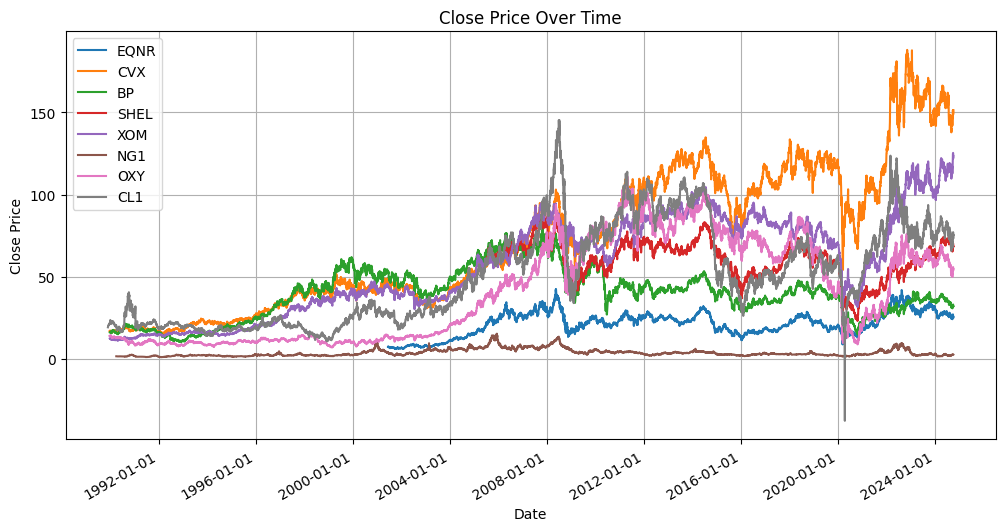

In [12]:
def plot_prices(tickers: Dict[str, pd.DataFrame]) -> None:
  plt.figure(figsize=(12, 6))
  for ticker in tickers.keys():
    df = tickers[ticker]
    plt.plot_date(df['date'], df['close'], label=ticker, fmt="-")  # Use plot_date
  plt.xlabel('Date')
  plt.ylabel('Close Price')
  plt.title('Close Price Over Time')
  plt.legend()
  plt.grid(True)
  # Format the x-axis to display dates properly
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
  plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
  plt.gcf().autofmt_xdate()  # Auto-format the dates
  plt.show()
plot_prices(tickers)

### Stocks and Futures price trend (For the duration of 2009 to 2024 data - our filtered dataset)

- steady growth until 2014
- collapse in oil prices for 2014-2016
- notable crash in 2020 because of covid-19
  - global lockdowns that slowed demand for fuel
  - oil futures even went negative in 2020
- recovery after 2020
- became more volatile again in 2022-2024 because of geopolitical tensions - middle east conflict and Russia-Ukraine war, OPEC+ production cuts etc

/var/folders/5n/7955wqx52_s2p0fymgbx_vsh0000gn/T/ipykernel_66937/264097068.py:5: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(df['date'], df['close'], label=ticker, fmt="-")  # Use plot_date


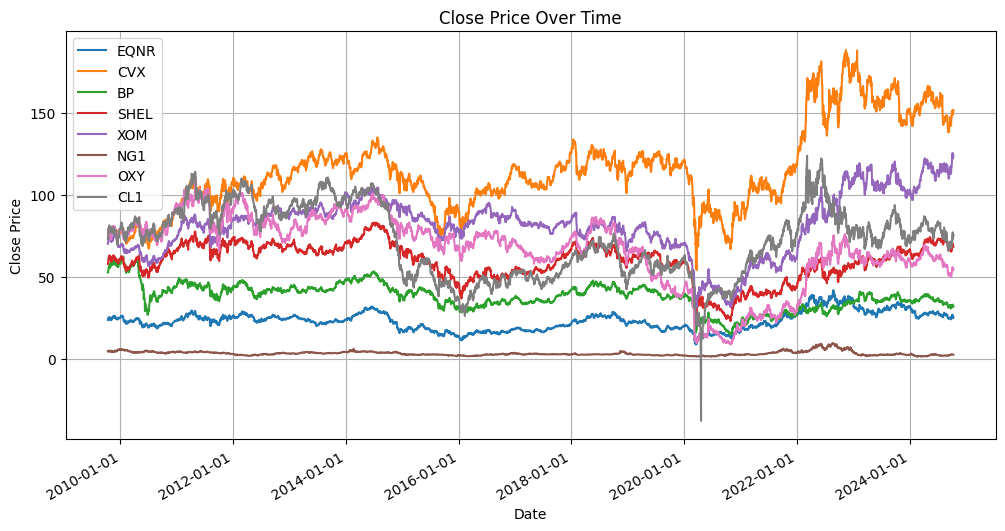

In [13]:
plot_prices(cleaned_tickers)

### Correlation of close prices across tickers

- strong positive correlations between BP, SHEL, and OXY
- strong positive correlations between CVX, EQNR, and XOM
- For CL1, a positive correlation was observed with EQNR, NG1, OXY, and SHEL
- NG1 showed a relatively weak correlation with the other instruments, except for a moderate positive correlation with EQNR and CL1 --> might not be as relevant to predicting oil and gas stocks

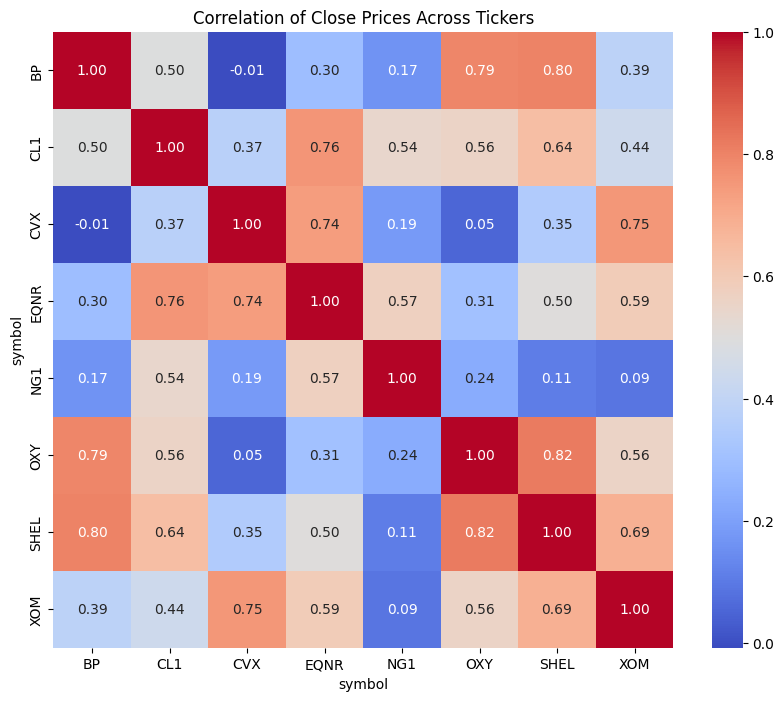

In [14]:
def plot_correlation_tickers(cleaned_tickers: Dict[str, pd.DataFrame]):
  combined_df = pd.concat(cleaned_tickers.values(), ignore_index=True)
  close_prices = combined_df.pivot(index='date', columns='symbol', values='close')
  correlation_matrix = close_prices.corr()
  plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
  sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
  plt.title('Correlation of Close Prices Across Tickers')
  plt.show()
  return correlation_matrix
correlation_matrix = plot_correlation_tickers(cleaned_tickers)

Hierarchical clustering confirmed the similarity between certain oil and gas companies

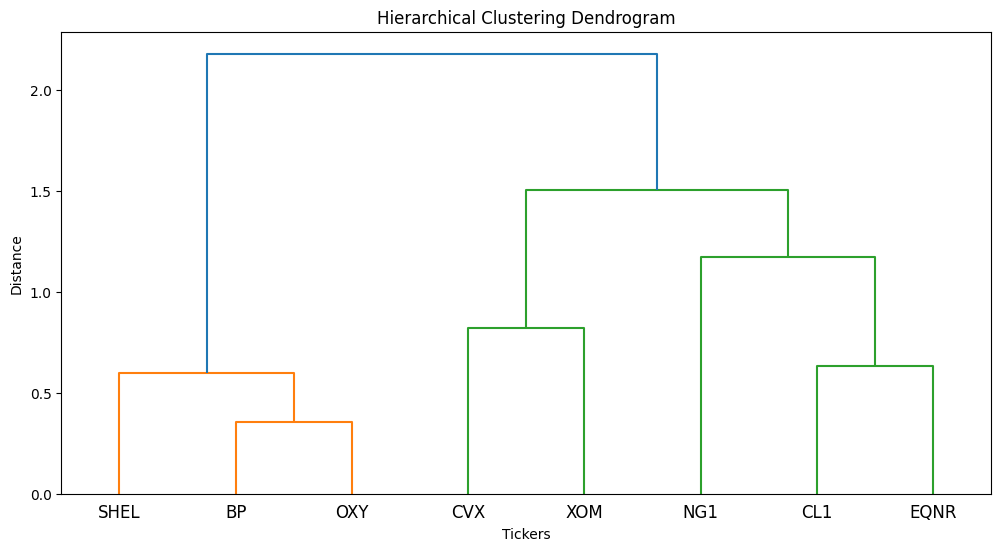

symbol  cluster
symbol         
BP            1
CL1           3
CVX           2
EQNR          3
NG1           3
OXY           1
SHEL          1
XOM           2


In [15]:
def find_grouped_tickers(correlation_matrix, threshold=0.9):
  linkage_matrix = linkage(correlation_matrix, method='ward') 
  
  plt.figure(figsize=(12, 6))
  dendrogram(linkage_matrix, labels=correlation_matrix.index, orientation='top')
  plt.title('Hierarchical Clustering Dendrogram')
  plt.xlabel('Tickers')
  plt.ylabel('Distance')
  plt.show()
  num_clusters = 3  
  clusters = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')
  correlation_matrix['cluster'] = clusters
  print(correlation_matrix[['cluster']]) 
find_grouped_tickers(correlation_matrix)


# Feature Engineering

In this section, we enrich our dataset by engineering new features using various technical indicators. Technical indicators are mathematical calculations applied to historical price and volume data to predict future price movements and identify trading opportunities.

We focused on indicators that capture different aspects of market behavior:

* **Trend:** Identifying the *direction* of price movement (e.g., Simple Moving Average - SMA, Weighted Moving Average - WMA, Exponential Moving Average - EMA)
* **Volatility:** Measuring *magnitude* of price fluctuations and risk (e.g., Standard Deviation - STD)
* **Momentum:** Assessing the *rate of price change* (e.g. Momentum, Moving Average Convergence Divergence - MACD, Relative Strength Index - RSI, Stochastic Oscillator)


In [16]:
def feature_generation(cleaned_tickers: Dict[str, pd.DataFrame]) -> Dict[str, pd.DataFrame]:
  for ticker in cleaned_tickers.keys():
      # Daily Variation
      cleaned_tickers[ticker]['daily_variation'] = cleaned_tickers[ticker]['high'] - cleaned_tickers[ticker]['low']
      # Daily Return
      cleaned_tickers[ticker]['daily_return'] = cleaned_tickers[ticker]['close'].pct_change()
      # 7-day SMA
      cleaned_tickers[ticker]['7day_SMA'] = cleaned_tickers[ticker]['close'].rolling(window=7).mean()
      # 7-day STD
      cleaned_tickers[ticker]['7day_STD'] = cleaned_tickers[ticker]['close'].rolling(window=7).std()
      # 30-day SMA
      cleaned_tickers[ticker]['30day_SMA'] = cleaned_tickers[ticker]['close'].rolling(window=30).mean()
      # 30-day STD
      cleaned_tickers[ticker]['30day_STD'] = cleaned_tickers[ticker]['close'].rolling(window=30).std()
      # 7-day WMA
      cleaned_tickers[ticker]['7day_WMA'] = cleaned_tickers[ticker]['close'].rolling(window=7).apply(lambda x: np.average(x, weights=np.arange(1, len(x)+1)))
      # 30-day WMA
      cleaned_tickers[ticker]['30day_WMA'] = cleaned_tickers[ticker]['close'].rolling(window=30).apply(lambda x: np.average(x, weights=np.arange(1, len(x)+1)))
      # 7-day EMA
      cleaned_tickers[ticker]['7day_EMA'] = cleaned_tickers[ticker]['close'].ewm(span=7, adjust=False).mean()
      # 30-day EMA
      cleaned_tickers[ticker]['30day_EMA'] = cleaned_tickers[ticker]['close'].ewm(span=30, adjust=False).mean()
      # Momentum (7-day) - You can adjust the period
      cleaned_tickers[ticker]['momentum'] = cleaned_tickers[ticker]['close'] - cleaned_tickers[ticker]['close'].shift(7)
      # MACD
      cleaned_tickers[ticker]['MACD'], cleaned_tickers[ticker]['MACD_signal'], cleaned_tickers[ticker]['MACD_hist'] = talib.MACD(cleaned_tickers[ticker]['close'], fastperiod=12, slowperiod=26, signalperiod=9)
      # RSI
      cleaned_tickers[ticker]['RSI'] = talib.RSI(cleaned_tickers[ticker]['close'], timeperiod=14)
      # Stochastic Oscillator
      cleaned_tickers[ticker]['slowk'], cleaned_tickers[ticker]['slowd'] = talib.STOCH(cleaned_tickers[ticker]['high'], cleaned_tickers[ticker]['low'], cleaned_tickers[ticker]['close'], slowk_period=5, slowk_matype=0, slowd_period=3, slowd_matype=0)
      # drop NA
      cleaned_tickers[ticker].dropna(inplace=True)
  return cleaned_tickers

cleaned_tickers = feature_generation(cleaned_tickers)

In [17]:
cleaned_tickers['BP']

,date,symbol,open,high,low,close,volume,daily_variation,daily_return,7day_SMA,...,30day_WMA,7day_EMA,30day_EMA,momentum,MACD,MACD_signal,MACD_hist,RSI,slowk,slowd
33,2009-11-26,BP,58.85001,59.30000,58.64000,59.22000,2812361.0,0.66000,0.000000,58.785716,...,58.380882,58.878845,57.578035,-0.28000,0.957407,1.172527,-0.215120,61.737046,66.149059,59.340682
34,2009-11-27,BP,56.71001,58.38800,56.60001,58.11000,3795646.0,1.78799,-0.018744,58.624286,...,58.401441,58.686634,57.612356,-1.13001,0.839019,1.105825,-0.266806,54.442732,73.039048,65.461931
35,2009-11-30,BP,57.03000,57.59000,56.71001,57.17999,5784098.0,0.87999,-0.016004,58.417141,...,58.355333,58.309973,57.584461,-1.45001,0.662514,1.017163,-0.354649,49.197869,65.943908,68.377338
36,2009-12-01,BP,58.32001,58.78999,58.22000,58.58000,3918975.0,0.56999,0.024484,58.524284,...,58.397870,58.377480,57.648689,0.75000,0.628359,0.939402,-0.311043,56.060321,68.523598,69.168851
37,2009-12-02,BP,58.53999,59.00000,58.37000,58.64000,3950568.0,0.63000,0.001024,58.524284,...,58.439118,58.443110,57.712645,0.00000,0.599225,0.871367,-0.272142,56.332566,64.446874,66.304793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3910,2024-10-07,BP,33.09000,33.29000,33.00500,33.14000,5836765.0,0.28500,0.007908,32.250000,...,32.250065,32.495690,32.597340,2.35000,-0.147581,-0.338265,0.190685,56.570300,88.559959,76.850166
3911,2024-10-08,BP,32.45000,32.47000,31.86000,32.03000,9039105.0,0.61000,-0.033494,32.337143,...,32.220215,32.379268,32.560738,0.61000,-0.163047,-0.303222,0.140175,45.656275,74.411083,79.867077
3912,2024-10-09,BP,31.67000,32.08000,31.59000,31.98000,6035177.0,0.49000,-0.001561,32.421429,...,32.192194,32.279451,32.523271,0.59000,-0.177295,-0.278036,0.100741,45.232941,61.505110,74.825384
3913,2024-10-10,BP,32.15000,32.40000,31.95000,32.34000,5886192.0,0.45000,0.011257,32.457143,...,32.192237,32.294588,32.511447,0.25000,-0.157719,-0.253973,0.096253,48.906329,52.348492,62.754895


In [18]:
cleaned_tickers['BP'].columns

Index(['date', 'symbol', 'open', 'high', 'low', 'close', 'volume',
       'daily_variation', 'daily_return', '7day_SMA', '7day_STD', '30day_SMA',
       '30day_STD', '7day_WMA', '30day_WMA', '7day_EMA', '30day_EMA',
       'momentum', 'MACD', 'MACD_signal', 'MACD_hist', 'RSI', 'slowk',
       'slowd'],
      dtype='object')

### Extended EDA

1. Summary statistics

In [19]:
for ticker in cleaned_tickers.keys():
  print(ticker)
  print(cleaned_tickers[ticker][['open', 'high', 'low', 'close', 'volume']].describe())
  print("\n")


EQNR
              open         high          low        close        volume
count  3882.000000  3882.000000  3882.000000  3882.000000  3.882000e+03
mean     23.172570    23.365348    22.961832    23.169606  2.412454e+06
std       5.672878     5.715830     5.616326     5.670330  1.546996e+06
min       9.090000     9.440000     8.410000     8.840000  1.956820e+05
25%      18.740000    18.853750    18.560000    18.745007  1.344316e+06
50%      23.030000    23.190000    22.830000    23.010000  2.034586e+06
75%      26.600008    26.780000    26.408750    26.607502  3.036228e+06
max      41.940000    42.530000    41.500000    41.940000  1.448515e+07


CVX
              open         high          low        close        volume
count  3882.000000  3882.000000  3882.000000  3882.000000  3.882000e+03
mean    115.157642   116.166954   114.083684   115.152619  8.208690e+06
std      25.156192    25.338046    24.958568    25.147674  4.045052e+06
min      55.260000    58.490000    51.600000    54.22

2. Boxplot of closing prices

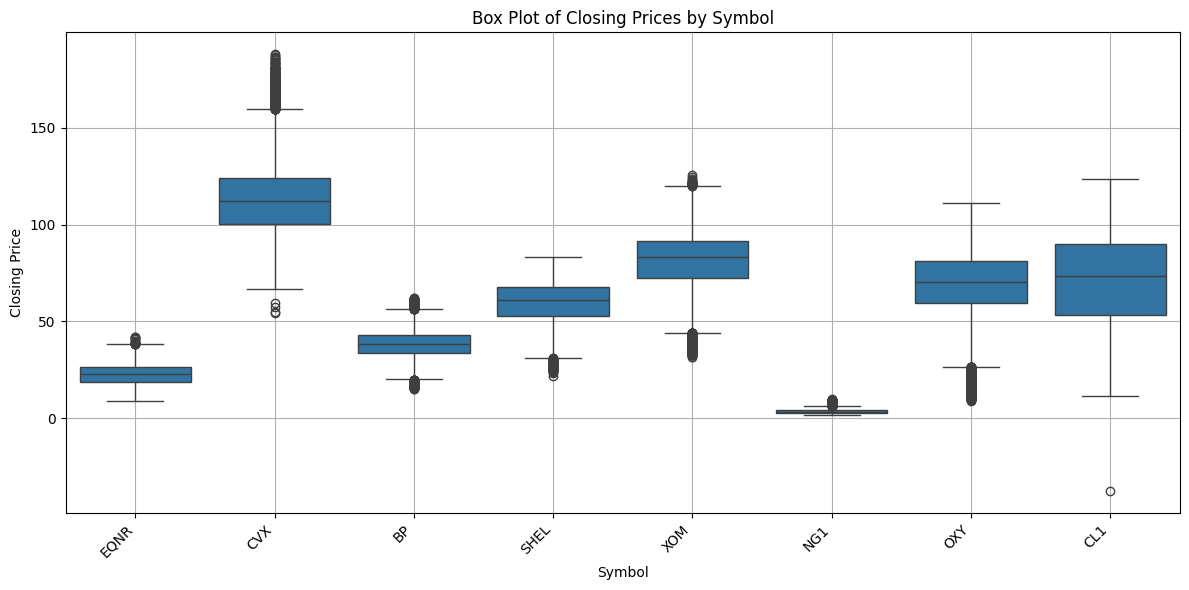

In [20]:
def boxplot_of_closing_prices(tickers):
  all_data = pd.concat(tickers.values(), keys=tickers.keys(), names=['symbol', None])
  plt.figure(figsize=(12, 6))  # Adjust figure size as needed
  sns.boxplot(x='symbol', y='close', data=all_data)
  plt.title('Box Plot of Closing Prices by Symbol')
  plt.xlabel('Symbol')
  plt.ylabel('Closing Price')
  plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels if needed
  plt.grid(True)
  plt.tight_layout()  # Adjust layout to prevent overlapping
  plt.show()
boxplot_of_closing_prices(cleaned_tickers)

3. Candlestick chart

In [21]:
def plot_candlestick(cleaned_tickers: Dict[str, pd.DataFrame], overlay_MA=False):
  for ticker in cleaned_tickers.keys():
    df = cleaned_tickers[ticker]
    fig = go.Figure(data=[go.Candlestick(x=df['date'],
                    open=df['open'],
                    high=df['high'],
                    low=df['low'],
                    close=df['close'])])

    if overlay_MA:  # Add moving averages if overlay_MA is True
      fig.add_trace(go.Scatter(x=df['date'], y=df['7day_SMA'], mode='lines', name='7-Day SMA'))
      fig.add_trace(go.Scatter(x=df['date'], y=df['30day_SMA'], mode='lines', name='30-Day SMA'))
      fig.add_trace(go.Scatter(x=df['date'], y=df['7day_WMA'], mode='lines', name='7-Day WMA'))
      fig.add_trace(go.Scatter(x=df['date'], y=df['30day_WMA'], mode='lines', name='30-Day WMA'))
      fig.add_trace(go.Scatter(x=df['date'], y=df['7day_EMA'], mode='lines', name='7-Day EMA'))
      fig.add_trace(go.Scatter(x=df['date'], y=df['30day_EMA'], mode='lines', name='30-Day EMA'))




    fig.update_layout(title=f'Candlestick Chart for {ticker}',
                      xaxis_title='Datetime',
                      yaxis_title='Price')
    fig.show()


start_date = dt.datetime(2024,7,11)
end_date = dt.datetime(2024,10,11)
cleaned_tickers_3_months = filter_by_date(start_date, end_date, cleaned_tickers)
plot_candlestick(cleaned_tickers_3_months)

4. Candlestick chart with moving averages

In [22]:
plot_candlestick(cleaned_tickers_3_months, overlay_MA = True)

5. Momentum

In [23]:
def prepare_data_for_momentum(cleaned_tickers: Dict[str, pd.DataFrame]):
  for ticker in cleaned_tickers.keys():
    df = cleaned_tickers[ticker]
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
  return cleaned_tickers

cleaned_tickers_3_months = prepare_data_for_momentum(cleaned_tickers_3_months)

/var/folders/5n/7955wqx52_s2p0fymgbx_vsh0000gn/T/ipykernel_66937/1560660282.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/5n/7955wqx52_s2p0fymgbx_vsh0000gn/T/ipykernel_66937/1560660282.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/5n/7955wqx52_s2p0fymgbx_vsh0000gn/T/ipykernel_66937/1560660282.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

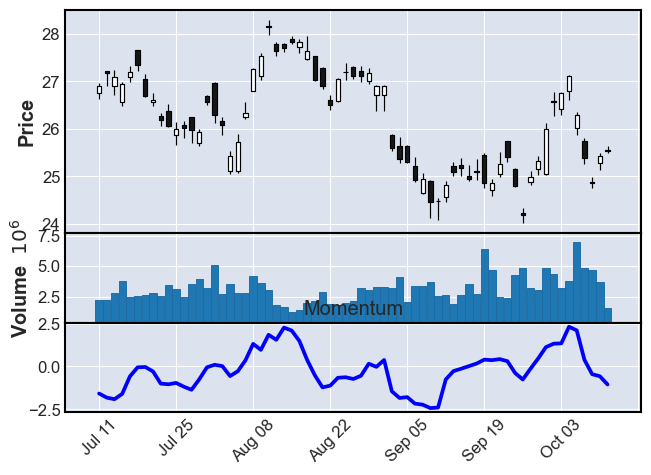

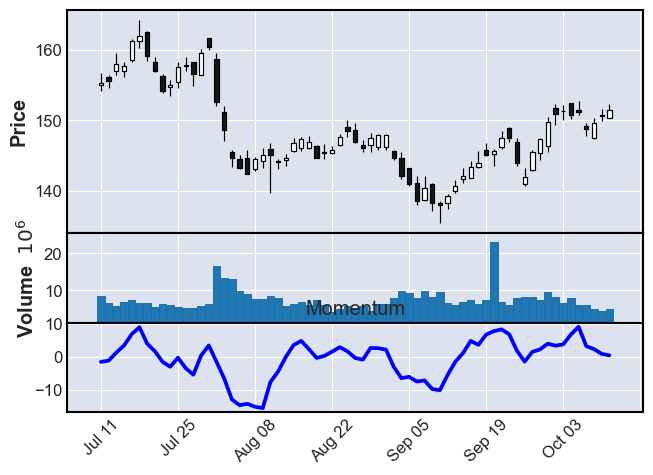

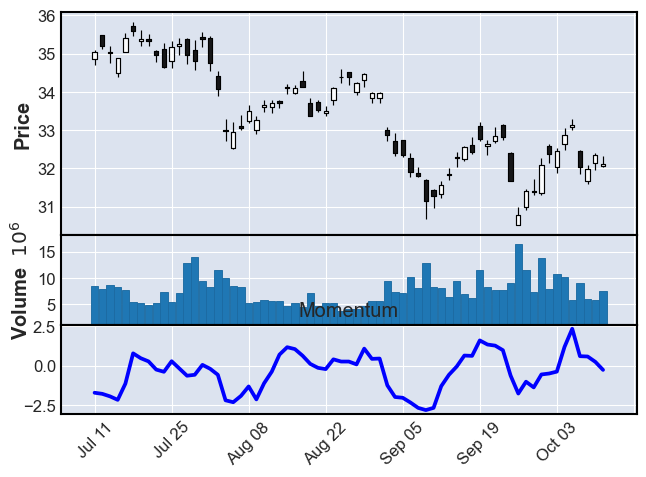

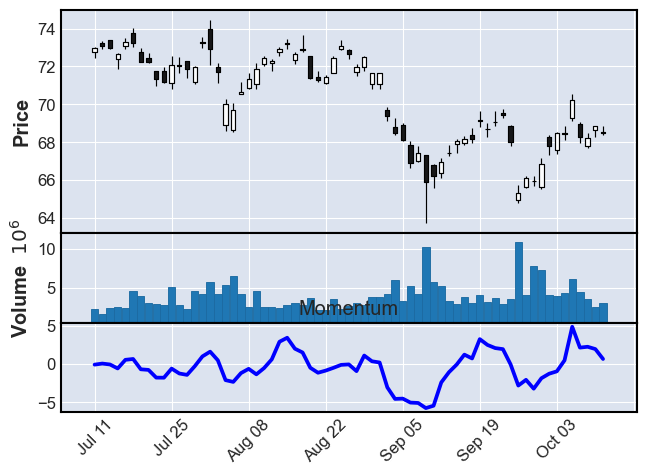

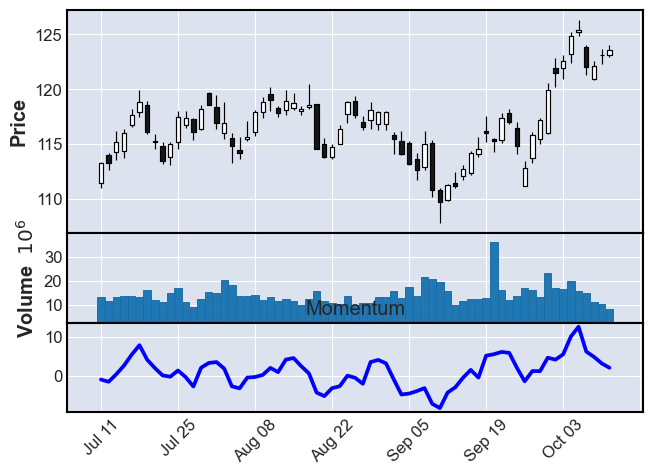

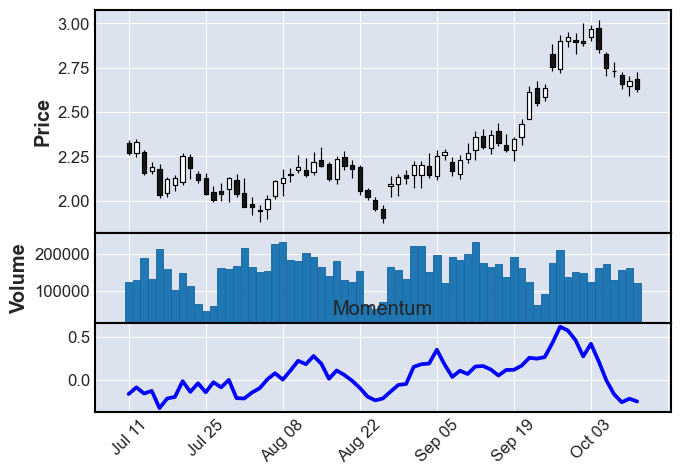

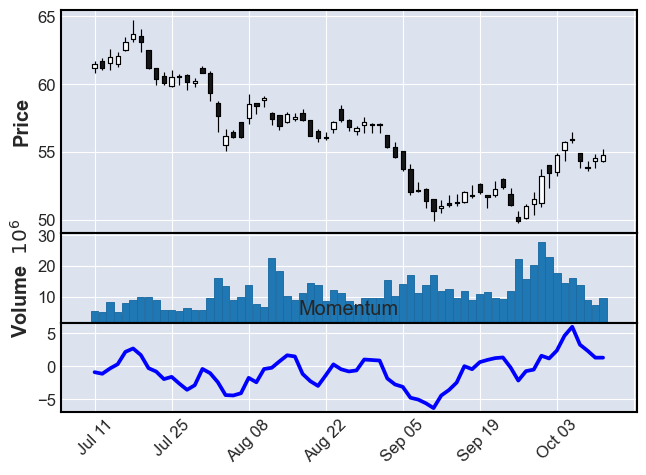

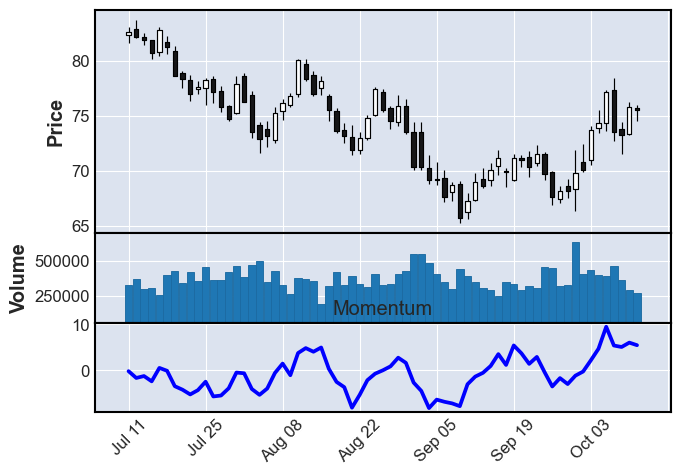

In [24]:
def plot_momentum(cleaned_tickers: Dict[str, pd.DataFrame]):
  for ticker in cleaned_tickers.keys():
    df = cleaned_tickers[ticker]
    mpf.plot(df, type='candle', volume=True,
          addplot=[mpf.make_addplot(df['momentum'], panel=2, color='blue', title='Momentum')])

plot_momentum(cleaned_tickers_3_months)

6. RSI

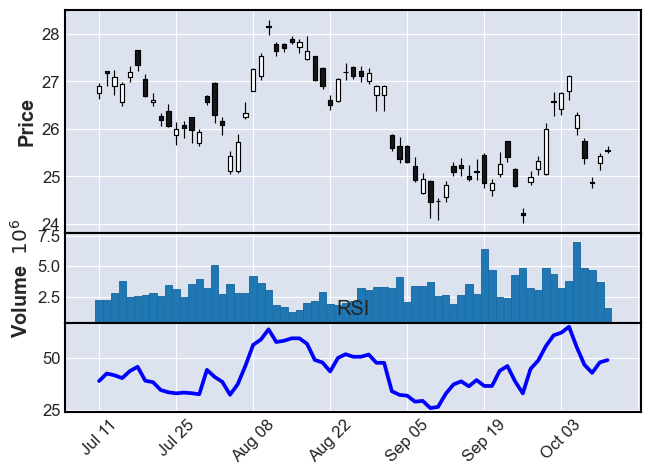

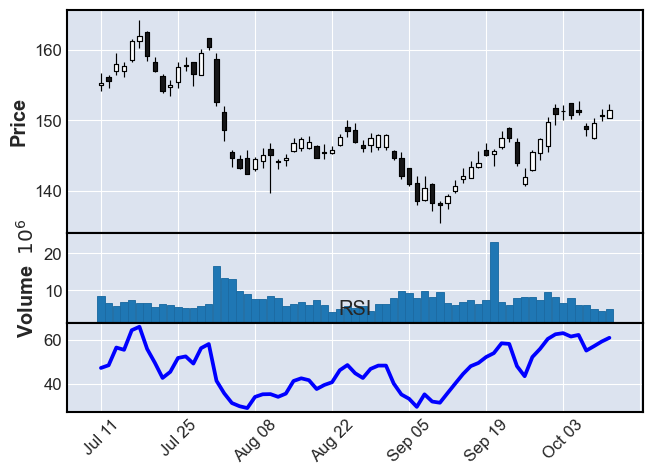

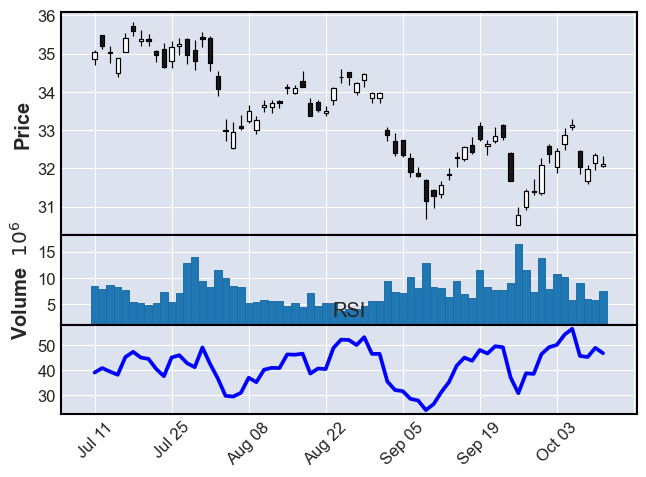

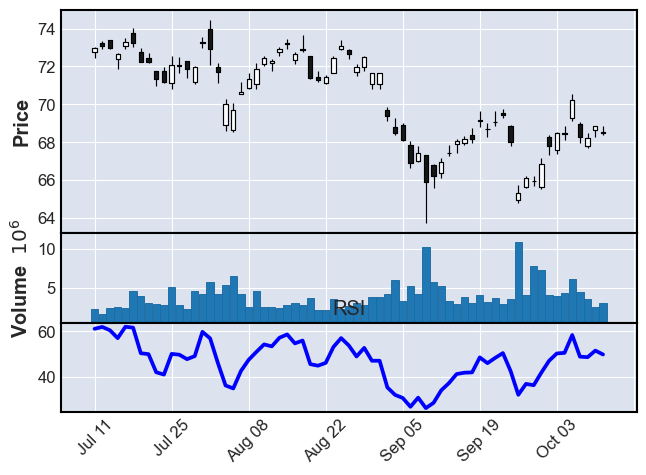

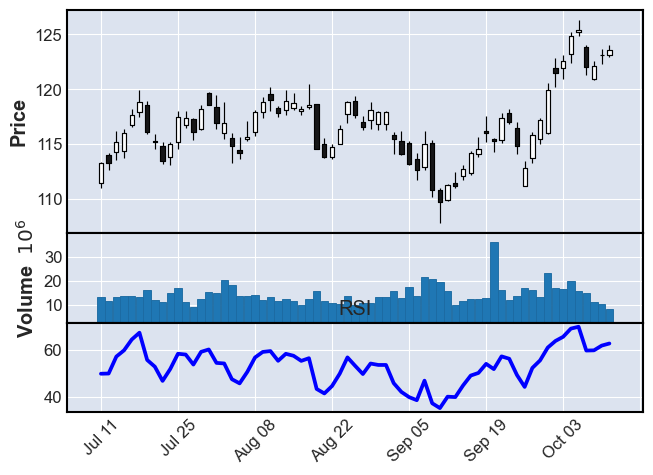

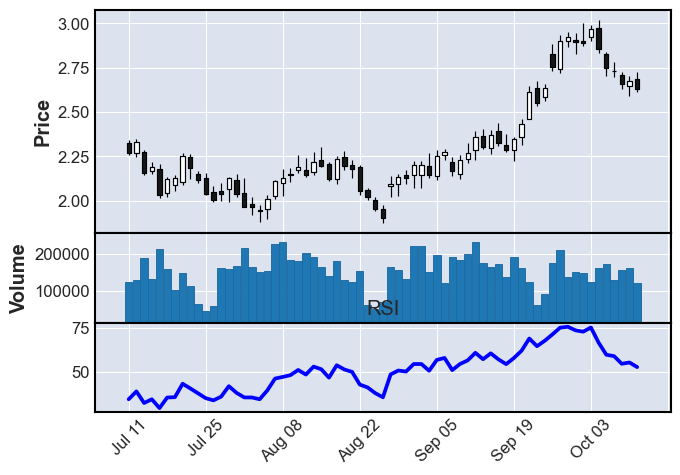

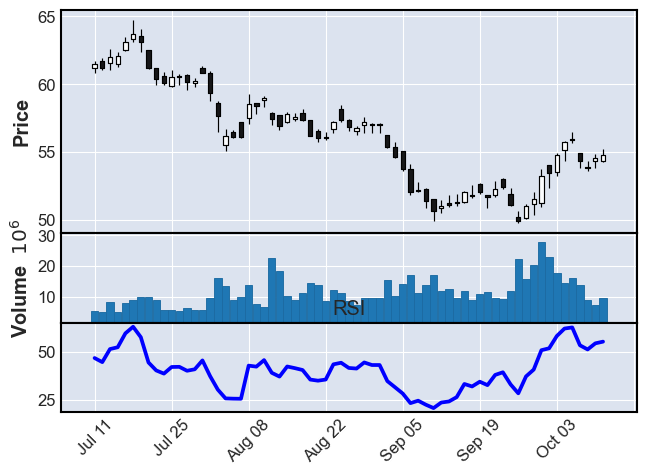

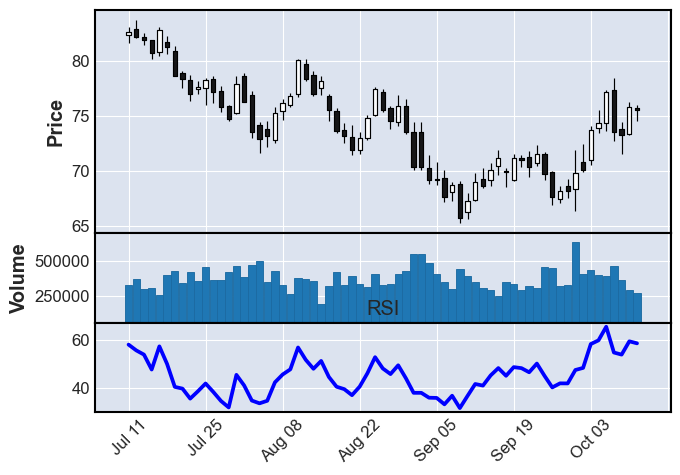

In [25]:
def plot_rsi(cleaned_tickers: Dict[str, pd.DataFrame]):
  for ticker in cleaned_tickers.keys():
    df = cleaned_tickers[ticker]
    mpf.plot(df, type='candle', volume=True,
          addplot=[mpf.make_addplot(df['RSI'], panel=2, color='blue', title='RSI')])
plot_rsi(cleaned_tickers_3_months)

7. MACD

Read [this](https://www.investopedia.com/terms/m/macd.asp#:~:text=the%20bearish%20trade.-,MACD%20Crossovers,price%20might%20experience%20upward%20momentum.) for the interpretation for MACD

<ipython-input-124-228f53a9c255>:8: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-124-228f53a9c255>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-124-228f53a9c255>:14: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-124-228f53a9c255>:17: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consis

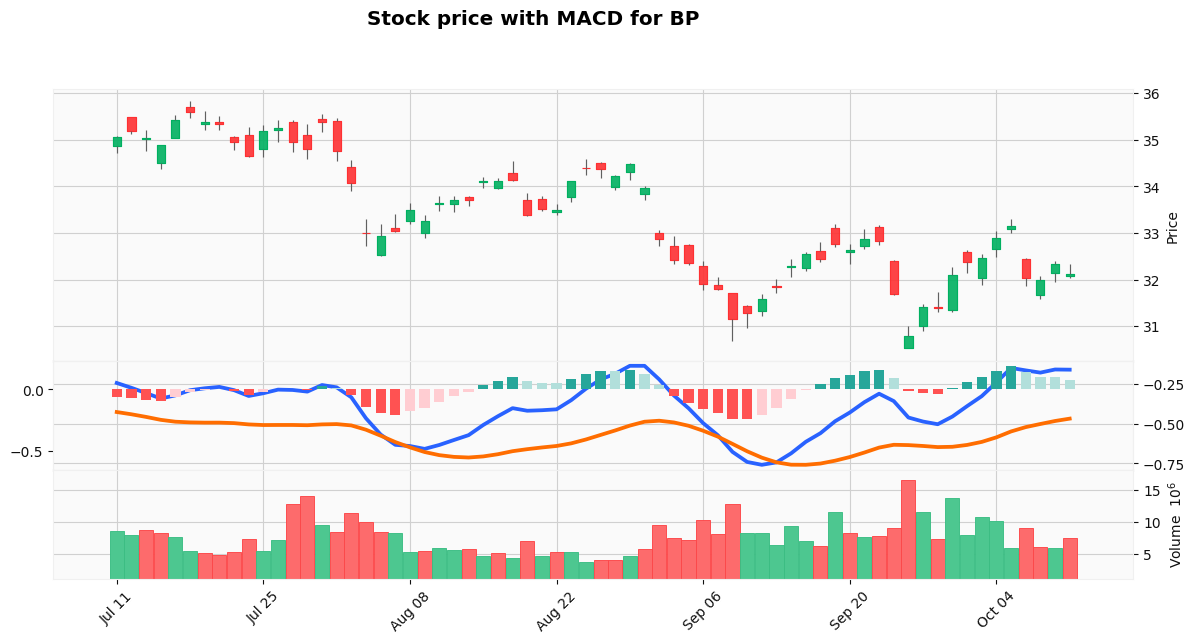

<ipython-input-124-228f53a9c255>:8: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-124-228f53a9c255>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-124-228f53a9c255>:14: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-124-228f53a9c255>:17: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consis

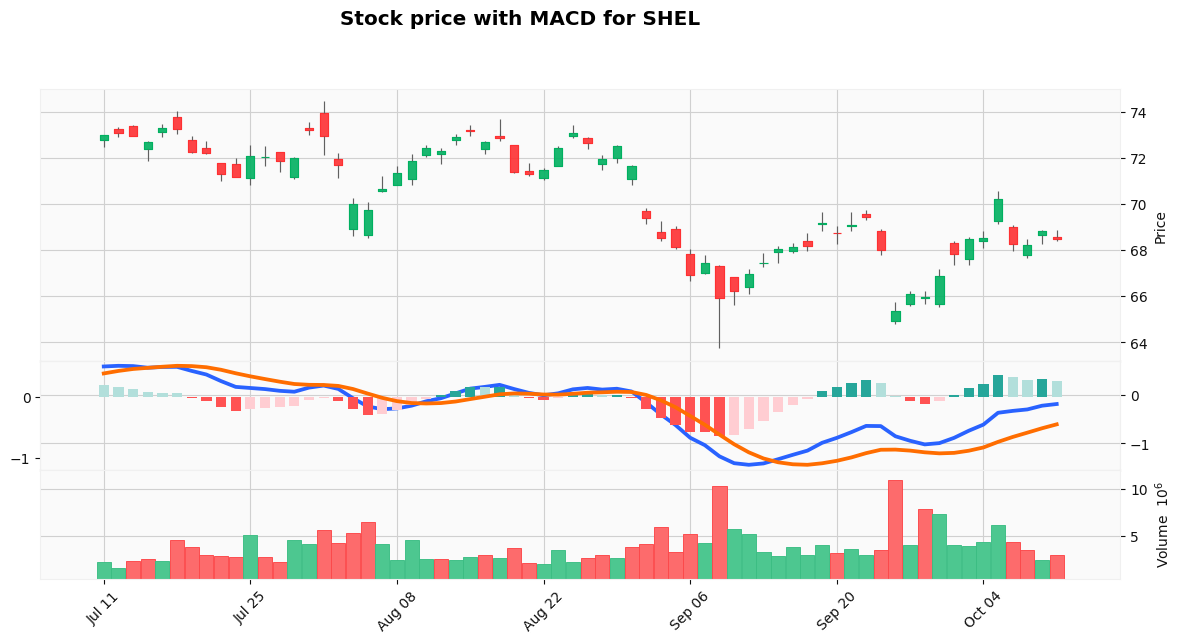

<ipython-input-124-228f53a9c255>:8: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-124-228f53a9c255>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-124-228f53a9c255>:14: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-124-228f53a9c255>:17: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consis

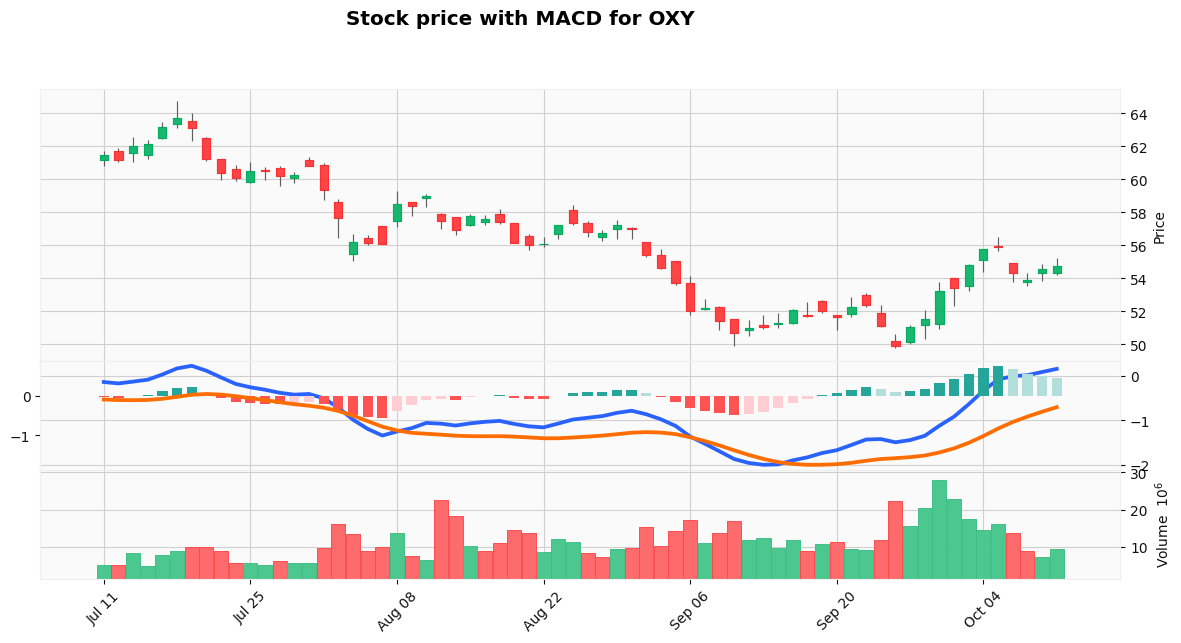

<ipython-input-124-228f53a9c255>:8: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-124-228f53a9c255>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-124-228f53a9c255>:14: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-124-228f53a9c255>:17: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consis

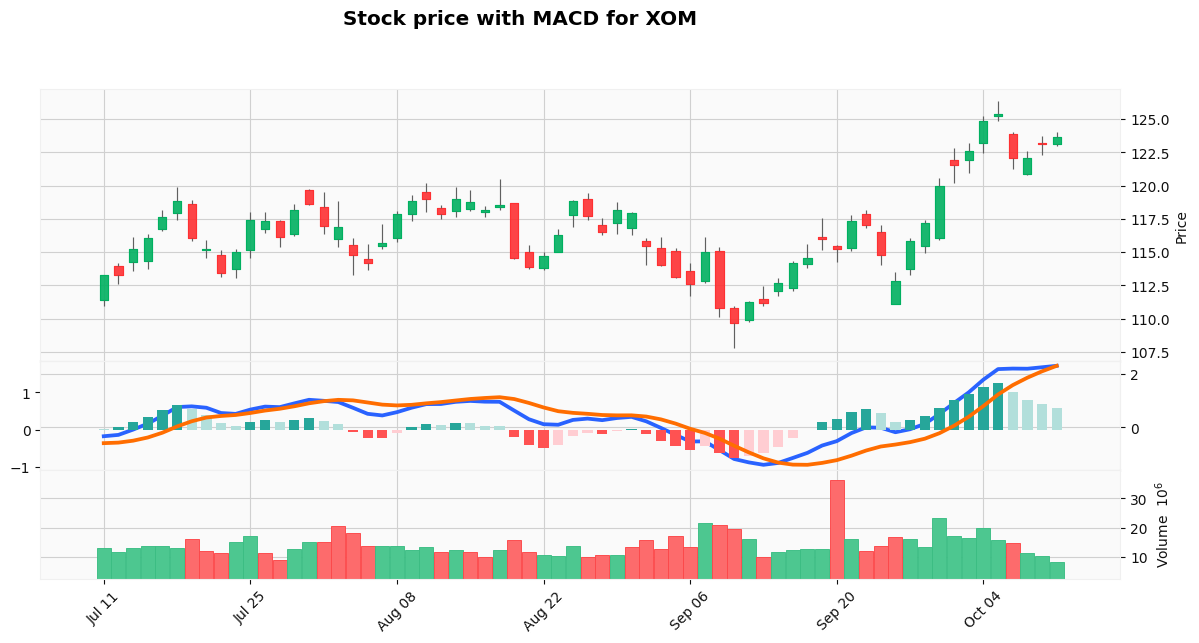

<ipython-input-124-228f53a9c255>:8: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-124-228f53a9c255>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-124-228f53a9c255>:14: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-124-228f53a9c255>:17: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consis

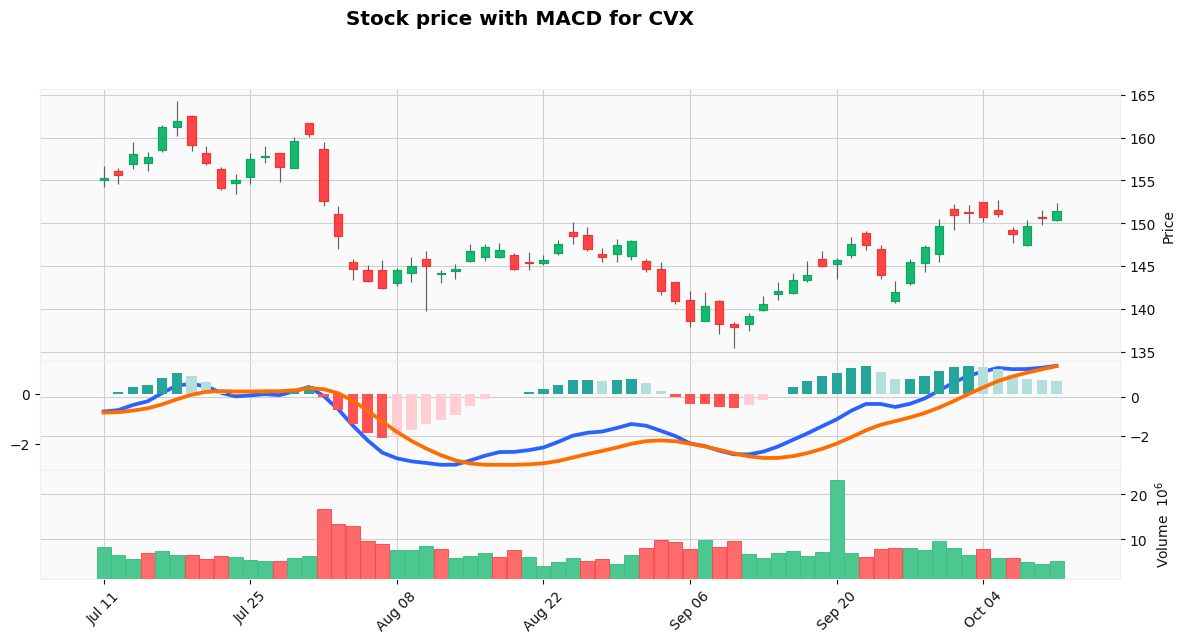

<ipython-input-124-228f53a9c255>:8: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-124-228f53a9c255>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-124-228f53a9c255>:14: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-124-228f53a9c255>:17: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consis

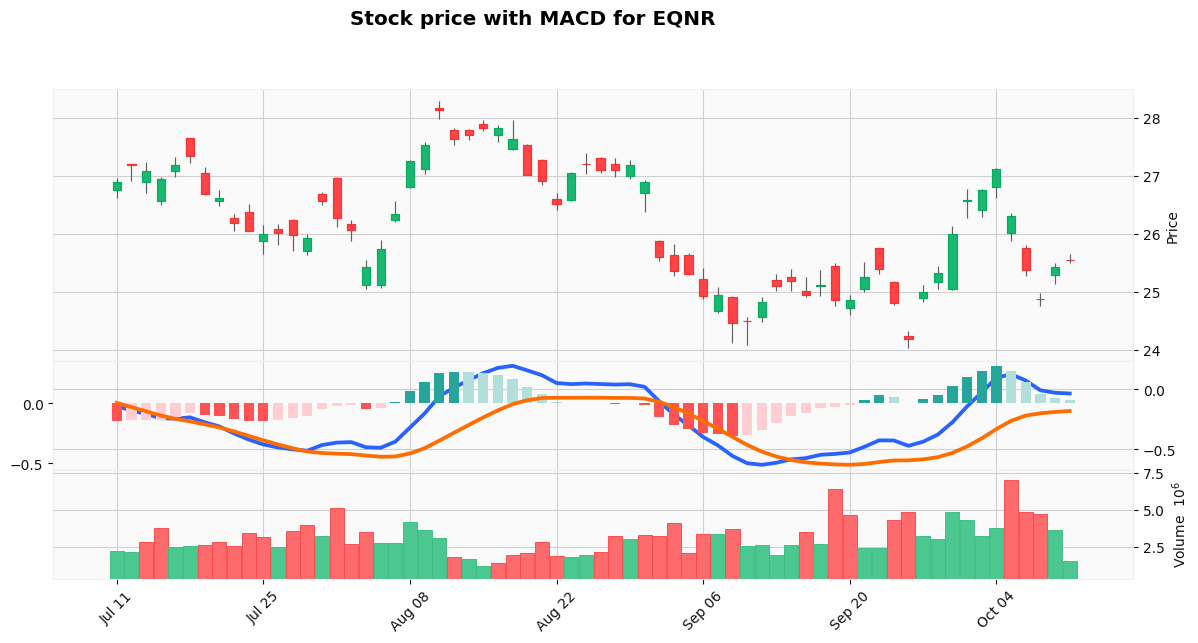

<ipython-input-124-228f53a9c255>:8: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-124-228f53a9c255>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-124-228f53a9c255>:14: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-124-228f53a9c255>:17: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consis

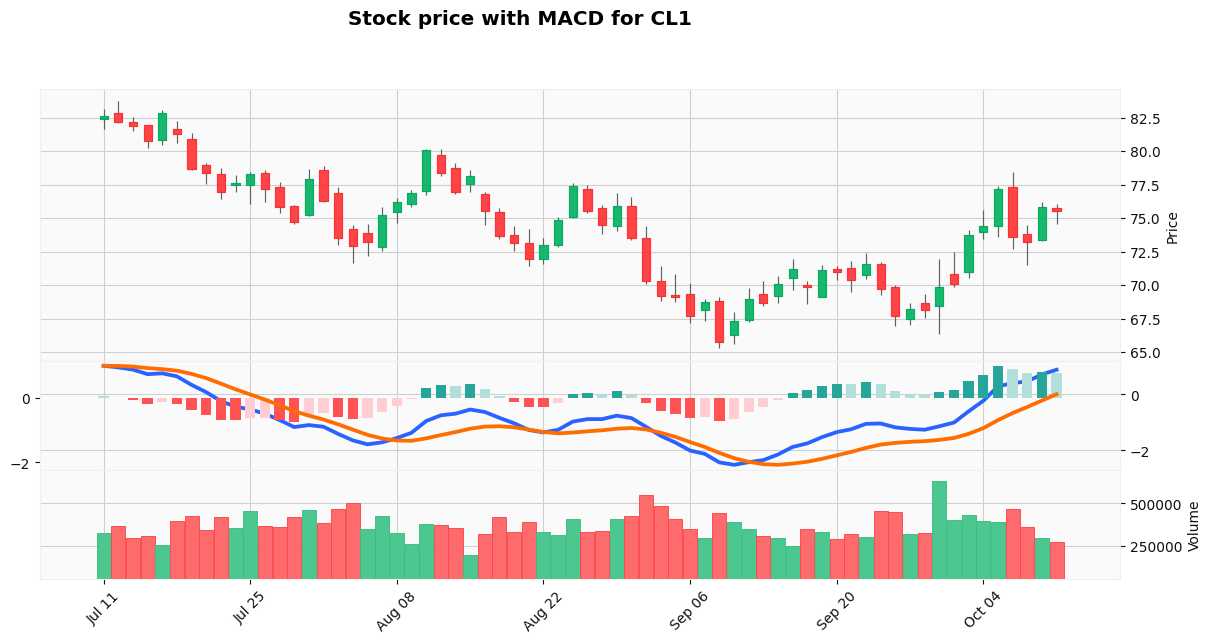

<ipython-input-124-228f53a9c255>:8: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-124-228f53a9c255>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-124-228f53a9c255>:14: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-124-228f53a9c255>:17: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consis

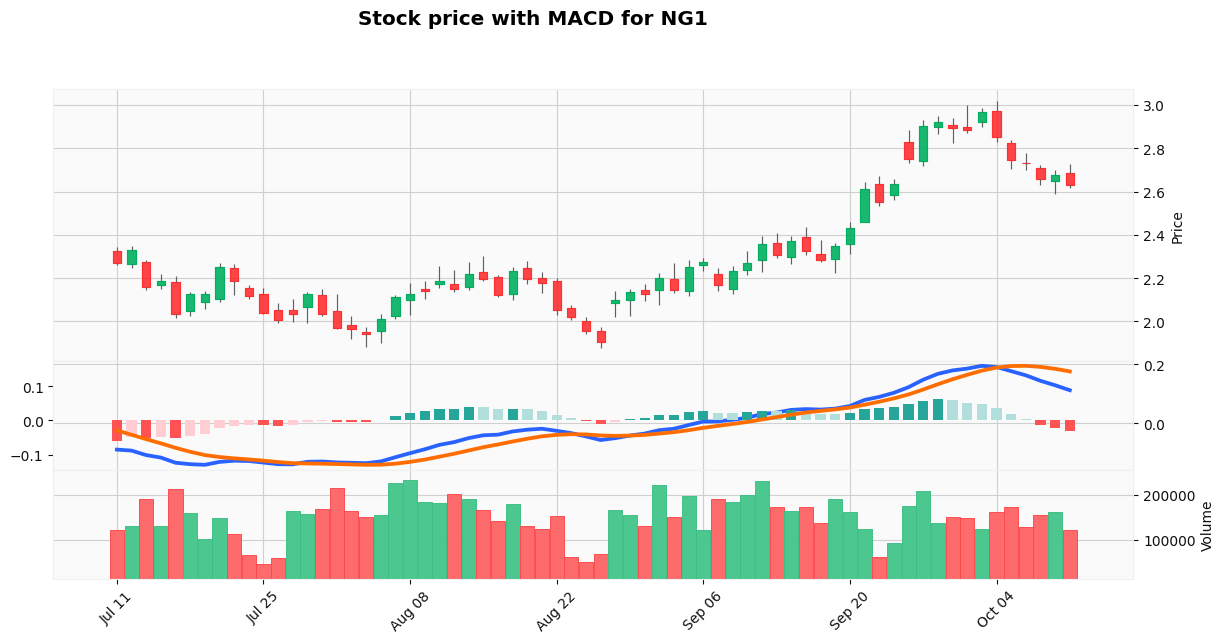

In [ ]:
def plot_macd(cleaned_tickers: Dict[str, pd.DataFrame]):
  def gen_macd_color(df):
    macd_color = []
    macd_color.clear()
    for i in range (0,len(df["MACD_hist"])):
        if df["MACD_hist"][i] >= 0 and df["MACD_hist"][i-1] < df["MACD_hist"][i]:
            macd_color.append('#26A69A')
            #print(i,'green')
        elif df["MACD_hist"][i] >= 0 and df["MACD_hist"][i-1] > df["MACD_hist"][i]:
            macd_color.append('#B2DFDB')
            #print(i,'faint green')
        elif df["MACD_hist"][i] < 0 and df["MACD_hist"][i-1] > df["MACD_hist"][i] :
            #print(i,'red')
            macd_color.append('#FF5252')
        elif df["MACD_hist"][i] < 0 and df["MACD_hist"][i-1] < df["MACD_hist"][i] :
            #print(i,'faint red')
            macd_color.append('#FFCDD2')
        else:
            macd_color.append('#000000')
            #print(i,'no')
    return macd_color
  for ticker in cleaned_tickers.keys():
    df = cleaned_tickers[ticker]
    macd_color = gen_macd_color(df)
    apds = [
              mpf.make_addplot(df['MACD'],color='#2962FF', panel=1),
              mpf.make_addplot(df['MACD_signal'],color='#FF6D00', panel=1),
              mpf.make_addplot(df['MACD_hist'],type='bar',width=0.7,panel=1, color=macd_color,alpha=1,secondary_y=True),
            ]
    mpf.plot(
              df,
              volume=True,
              type="candle",
              style="yahoo",
              addplot=apds,
              volume_panel=2,
              figsize=(15,7),
              title=f"Stock price with MACD for {ticker}",
              )

plot_macd(cleaned_tickers_3_months)

8. Stochastic Oscillator

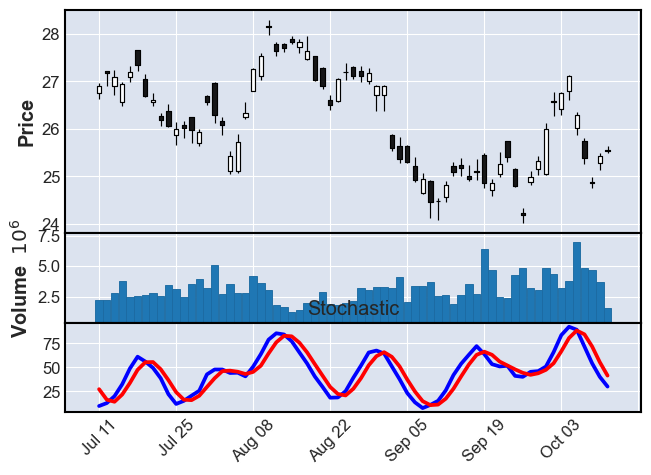

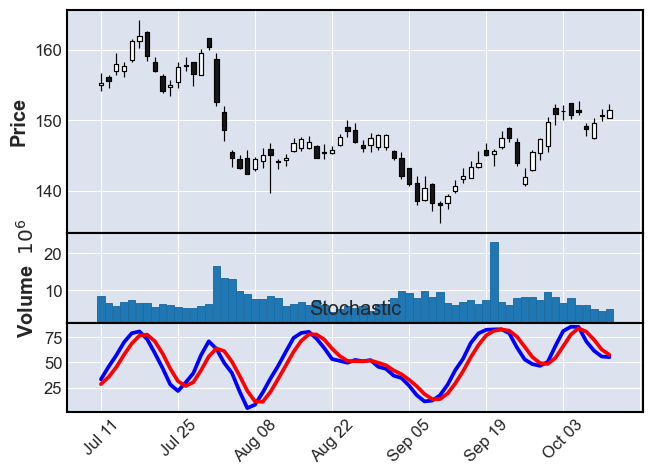

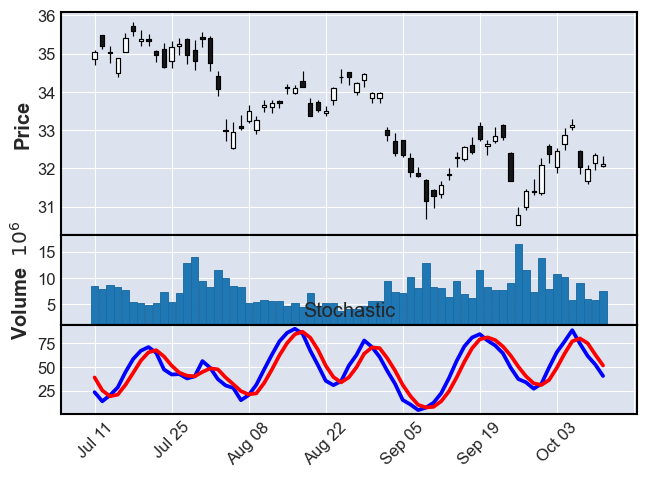

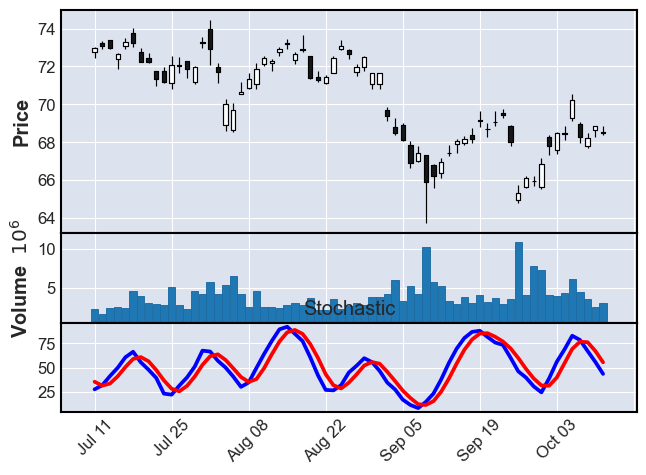

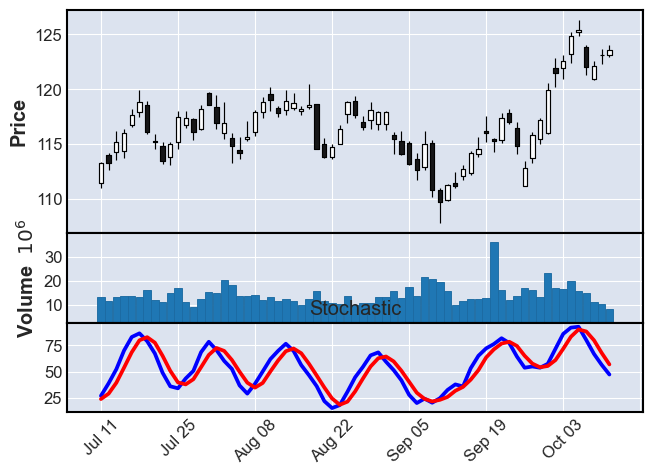

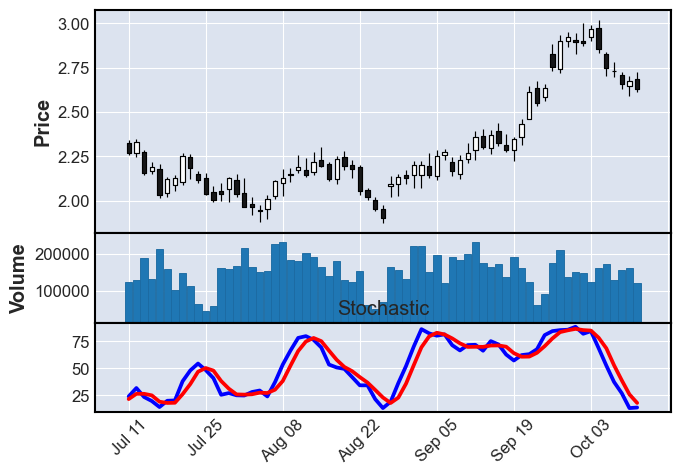

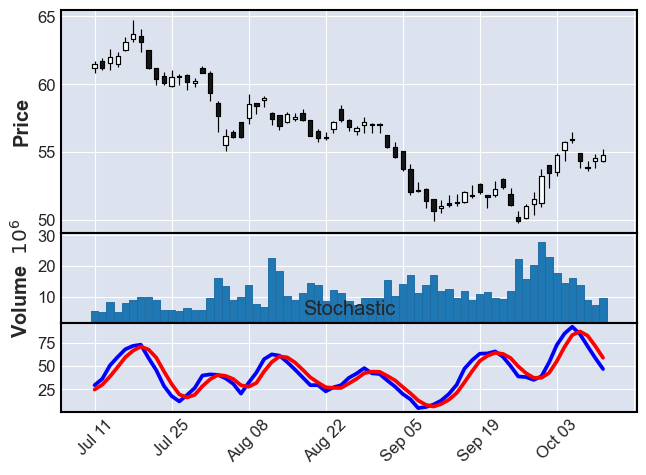

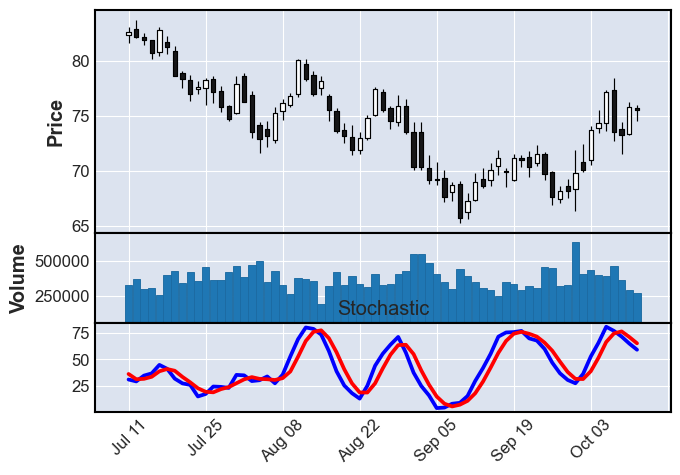

In [26]:
def plot_stochastic(cleaned_tickers: Dict[str, pd.DataFrame]):
  for ticker in cleaned_tickers.keys():
    df = cleaned_tickers[ticker]
    apds = [mpf.make_addplot(df['slowk'], panel=2, color='blue', title='Stochastic'),
            mpf.make_addplot(df['slowd'], panel=2, color='red')]

    mpf.plot(df, type='candle', volume=True, addplot=apds)
plot_stochastic(cleaned_tickers_3_months)

# Partitioning the Dataset


train test split (around 75-25)

In [28]:
all_data = pd.concat(cleaned_tickers.values(), ignore_index=True)
# Define the split date
split_date = dt.datetime(2020,10,10)

# Split the data into train and test
train_df = all_data[all_data['date'] <= split_date]
test_df = all_data[all_data['date'] > split_date]

In [34]:
processed_data_fpath = os.path.join(data_fpath, 'processed-data')
os.makedirs(processed_data_fpath, exist_ok=True)
train_df.to_csv(os.path.join(processed_data_fpath, 'train_data.csv'), index=False)
test_df.to_csv(os.path.join(processed_data_fpath, 'test_data.csv'), index=False)

Normalisation using MinMaxScalar and feature selection will be applied where appropriate for each model